# Dan Vecellio

## Homework 05

### Due Tuesday, March 29th

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial, interpolate
import shapely.geometry
import shapely.ops
from shapely.ops import polygonize
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### 1. Flyover states

_[This is very similar to the exercise done in class. This is a continuation.]_

What states do you see when you fly from LA (airport code LAX) to NYC (airport code EWR)?

> LAX: 33.9425° N, 118.4081° W

> EWR: 40.6925° N, 74.1686° W

Load in the `states_21basic` shapefile using these commands:

    from mpl_toolkits.basemap import Basemap
    m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
            urcrnrlon=-50.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',projection='merc',
            lat_0=40.,lon_0=-100.,lat_ts=20.)
    m.readshapefile('../materials/states_21basic/states', 'states')

The boundary information for all of the states is now held in an attribute of the map object `m.states`, which is a list of lists of x-y pairs denoting the boundaries. Next use the `m.gcpoints` function to get the points along the great circle path. Convert all of these things into Shapely objects, and check for intersections. Add a buffer of 100km to the flight path to see what states you might potentially see along the way. Use this analysis to provide the following:

1. Create and display a map that shows the flight path, with the states that are seen along the flight path clearly highlighted in some way.

2. Use the information in m.states_info to extract and print a list containing the names of the states seen, with unique names. (see `np.unique`)


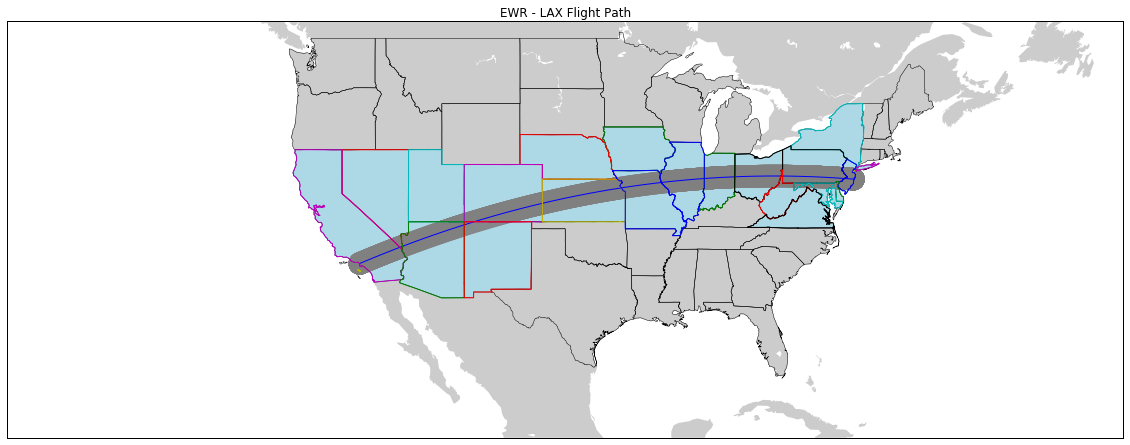

In [205]:
fig = plt.figure(figsize=(20,20))

m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
states = m.readshapefile('../python4geosciences/materials/states_21basic/states', 'states')
m.fillcontinents()

lats = [33.9425,40,6925]
lons = [-118.4081,-74.1686]
x,y = m.gcpoints(lons[0],lats[0],lons[1],lats[1],100)
plt.plot(x,y)

polys = []
for state in m.states:
    polys.append(shapely.geometry.Polygon(state))

point1 = shapely.geometry.Point(x[0], y[0])
point2 = shapely.geometry.Point(x[99],y[99])

point = []
for i in range(0,len(x)):
    point.append(shapely.geometry.Point(x[i], y[i]))
line = shapely.geometry.LineString(point).buffer(100000)
    
state_list = []
for i in range(len(polys)):
    if polys[i].intersects(line):
        color = 'lightblue'
        state_list.append(m.states_info[i]['STATE_NAME'])
    else:
        continue
    coords = shapely.ops.cascaded_union(polys[i].boundary).coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color)
    plt.fill(*line.boundary.xy, color='gray', alpha=0.9)
    plt.plot(x,y, '-')
    plt.title('EWR - LAX Flight Path')

state_sects = np.unique(state_list)

In [203]:
state_sects

array(['Arizona', 'California', 'Colorado', 'Delaware', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Maryland', 'Missouri', 'Nebraska',
       'Nevada', 'New Jersey', 'New Mexico', 'New York', 'Ohio',
       'Pennsylvania', 'Utah', 'Virginia', 'West Virginia'], 
      dtype='|S13')

### 2. Area in a Voronoi diagram

Given the series of points:

     np.array([[ 0.77354201,  0.34072038],
               [ 0.43807549,  0.93001924],
               [ 0.5624092 ,  0.79438991],
               [ 0.02536295,  0.46180244],
               [ 0.59533179,  0.07522803],
               [ 0.47867418,  0.70302822],
               [ 0.30371564,  0.83135442],
               [ 0.5856915 ,  0.16340903],
               [ 0.14700491,  0.60268997],
               [ 0.97098631,  0.51692456]])
               
create a Voronoi diagram, and calculate the area contained in the finite regions. What fraction of the total area is at least 0.001 unit away from any boundary? 0.01 away? And 0.1 away?


The total area of the polygon is 0.336210821531
The fraction of area within 0.001 units away from any boundary is 99.6287282843%.
The fraction of area within 0.01 units away from any boundary is 96.2494767098%.
The fraction of area within 0.1 units away from any boundary is 59.3243925265%.


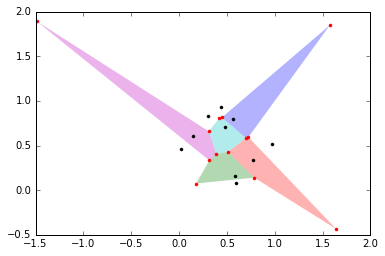

In [236]:
pts = np.array([[ 0.77354201,  0.34072038],
           [ 0.43807549,  0.93001924],
           [ 0.5624092 ,  0.79438991],
           [ 0.02536295,  0.46180244],
           [ 0.59533179,  0.07522803],
           [ 0.47867418,  0.70302822],
           [ 0.30371564,  0.83135442],
           [ 0.5856915 ,  0.16340903],
           [ 0.14700491,  0.60268997],
           [ 0.97098631,  0.51692456]])

vor = spatial.Voronoi(pts)

for indices in vor.regions:
    if not indices: continue
    if -1 in indices: continue
    plt.fill(vor.vertices[indices,0], vor.vertices[indices,1], edgecolor = 'none', alpha=0.3)
plt.plot(pts[:,0],pts[:,1],'.k')
plt.plot(vor.vertices[:,0],vor.vertices[:,1],'.r')

lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]

buffers = [0,-0.001,-0.01,-0.1]
convex_hulls = []
for j in buffers:
    convex_hull = MultiPoint([Point(i) for i in pts]).convex_hull.buffer(j)
    result = MultiPolygon(
        [poly.intersection(convex_hull) for poly in polygonize(lines)])
    convex_hulls.append(result)

print "The total area of the polygon is "+str(convex_hulls[0].area)+''
print "The fraction of area within 0.001 units away from any boundary is "\
       +str((convex_hulls[1].area/convex_hulls[0].area)*100)+'%.'
print "The fraction of area within 0.01 units away from any boundary is "\
       +str((convex_hulls[2].area/convex_hulls[0].area)*100)+'%.'
print "The fraction of area within 0.1 units away from any boundary is "\
       +str((convex_hulls[3].area/convex_hulls[0].area)*100)+'%.'

### 3. 2D interpolation

Data (found in `python4geosciences/data/MS03_L15.txt`) gathered from a field cruise out of the TAMU Oceanography department is randomly located in space (that is, unstructured) because of the nature of the measurement: the instrument is lowered into the water from a ship, and is brought up and down through the water column as the ship moves to get a sampling of the fields.

Read in the data file and plot the temperature in a `scatter` plot as a function of depth and latitude. Next, interpolate the temperature data to be on a uniform grid (to make it structured). Now, plot it using `contourf`, which requires structured data. Experiment with different spacing in your uniform grid, and with different numbers of contours to see how the results change, and choose values that provide a nice-looking image which closely resembles the original data.

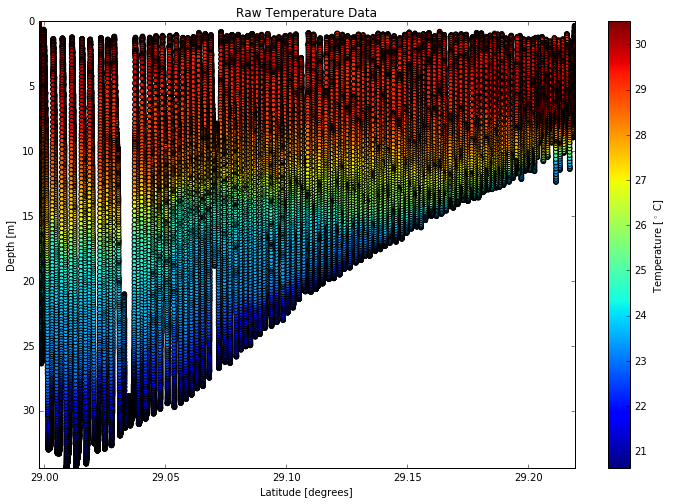

In [195]:
data  = np.genfromtxt('../python4geosciences/data/MS03_L15.txt',skip_header=114)
lat   = data[:,0]
depth = data[:,2]
temp  = data[:,3]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

mappable = ax1.scatter(lat,depth,c=temp,cmap='jet')
ax1.set_ylim(np.min(depth),np.max(depth))
ax1.set_xlim(np.min(lat),np.max(lat))
ax1.invert_yaxis()
ax1.set_xlabel('Latitude [degrees]')
ax1.set_ylabel('Depth [m]')
ax1.set_title('Raw Temperature Data')
plt.colorbar(mappable, label='Temperature [$^\circ$ C]')

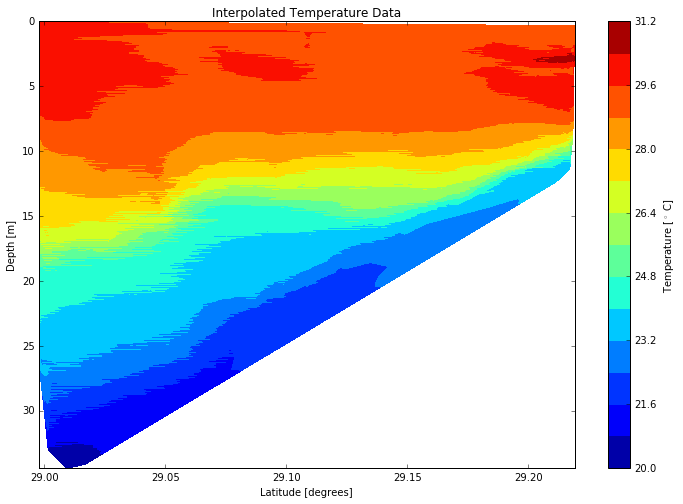

In [194]:
coords = zip(lat,depth)

tri = spatial.Delaunay(coords)
interp = interpolate.LinearNDInterpolator(tri,temp)
xgrid, ygrid = np.mgrid[np.min(lat):np.max(lat):5000j, np.min(depth):np.max(depth):5000j]
zgrid = interp(xgrid,ygrid)
zgrid = np.ma.masked_where(np.isnan(zgrid),zgrid)

fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111)

mappable = ax2.contourf(xgrid,ygrid,zgrid,15,cmap='jet')
ax2.invert_yaxis()
ax2.set_xlabel('Latitude [degrees]')
ax2.set_ylabel('Depth [m]')
ax2.set_title('Interpolated Temperature Data')
plt.colorbar(mappable, label='Temperature [$^\circ$ C]')

### 4. (Grad) Area of Greenland and Australia in different projections

Set up Basemap instances of the following projections: Mercator, Robinson, and Mollweide; make sure that all three projections are set up to show both Greenland and Australia at the same time (this is necessary for Mercator in particular). Plot them side-by-side to see how they compare.

Next, read in the shape files for Greenland and Australia, found in the `data` directory; you can do this with something like the following (but you might need to change the directory path):

> m.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
> m.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

where `m` is a `Basemap` instance. This gives you a series of polygons that make up each country, saved in `m.greenland` and `m.australia`. Find the area of the two countries in each projection and compare them. What is the area of Australia relative to the area of Greenland for each projection, and how does this compare to what it is in reality?

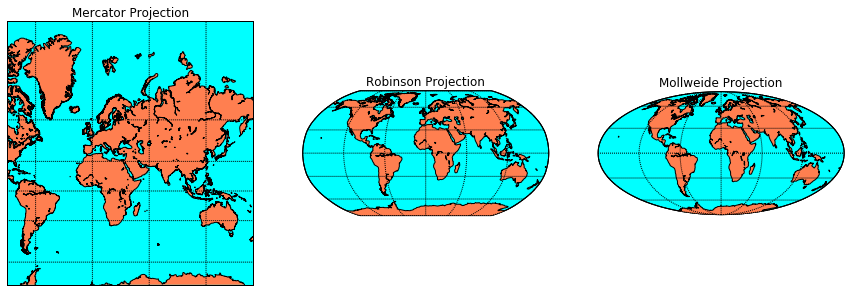

In [223]:
fig4 = plt.figure(figsize=(15,15))
ax1 = fig4.add_subplot(131)

m1 = Basemap(llcrnrlon=-90.,llcrnrlat=-70.,
        urcrnrlon=170.,urcrnrlat=85.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc')
m1.drawcoastlines()
m1.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m1.drawparallels(np.arange(-90.,120.,30.))
m1.drawmeridians(np.arange(0.,420.,60.))
m1.drawmapboundary(fill_color='aqua')
ax1.set_title('Mercator Projection')

ax2 = fig4.add_subplot(132)
m2 = Basemap(projection='robin',lon_0=0,resolution='c')
m2.drawcoastlines()
m2.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m2.drawparallels(np.arange(-90.,120.,30.))
m2.drawmeridians(np.arange(0.,420.,60.))
m2.drawmapboundary(fill_color='aqua')
ax2.set_title('Robinson Projection')

ax3 = fig4.add_subplot(133)
m3 = Basemap(projection='moll',lon_0=0,resolution='c')
m3.drawcoastlines()
m3.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m3.drawparallels(np.arange(-90.,120.,30.))
m3.drawmeridians(np.arange(0.,420.,60.))
m3.drawmapboundary(fill_color='aqua')
ax3.set_title('Mollweide Projection')

The Mercator projection shows the largest difference between the areas of Greenland and Australia. As latitudes are stretched at the top of the map in Mercator, Greenland looks three of four times bigger than Australia. The two countries look nearly equal in size in the Robinson projection. In Mollweide, the upper latitudes near the equator appear to be pinched and Australia actually looks about twice as big as Greenland.

In [240]:
m1.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
AUSmerc = 0
for state in m1.australia:
    AUSmerc += shapely.geometry.Polygon(state).area 
    
print "Australia Mercator Area (sq m):"+str(AUSmerc)+''

m1.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
GREmerc = 0
for state in m1.greenland:
    GREmerc += shapely.geometry.Polygon(state).area 
    
print "Greenland Mercator Area (sq m):"+str(GREmerc)+''


m2.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
AUSrob = 0
for state in m2.australia:
    AUSrob += shapely.geometry.Polygon(state).area 
    
print "Australia Robinson Area (sq m):"+str(AUSrob)+''

m2.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
GRErob = 0
for state in m2.greenland:
    GRErob += shapely.geometry.Polygon(state).area 
    
print "Greenland Robinson Area (sq m):"+str(GRErob)+''


m3.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
AUSmol = 0
for state in m3.australia:
    AUSmol += shapely.geometry.Polygon(state).area 
    
print "Australia Mollweide Area (sq m):"+str(AUSmol)+''

m3.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
GREmol = 0
for state in m3.greenland:
    GREmol += shapely.geometry.Polygon(state).area 
    
print "Greenland Mollweide area (sq m):"+str(GREmol)+''

Australia Mercator Area (sq m):9.59729589587e+12
Greenland Mercator Area (sq m):3.49319440944e+13
Australia Robinson Area (sq m):6.79169051863e+12
Greenland Robinson Area (sq m):3.42307733214e+12
Australia Mollweide Area (sq m):7.69960926928e+12
Greenland Mollweide area (sq m):2.13444086263e+12


In [239]:
GREarea = 836300.*2589988.11 #square miles
AUSarea = 2970000.*2589988.11 #square miles

real_AUSGRE_ratio = AUSarea/GREarea
print "Greenland's actual area is "+str(GREarea)+' square meters.'
print "Australia's actual area is "+str(AUSarea)+' square meters.'
print 'Australia is actually '+str(real_AUSGRE_ratio)+' times bigger than Greenland'

Greenland's actual area is 2.16600705639e+12 square meters.
Australia's actual area is 7.6922646867e+12 square meters.
Australia is actually 3.55135716848 times bigger than Greenland


The Mollweide projection provides the closest estimatation to the actual areas of Greenland and Australia.